In [1]:
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import numpy as np
import torch
import math

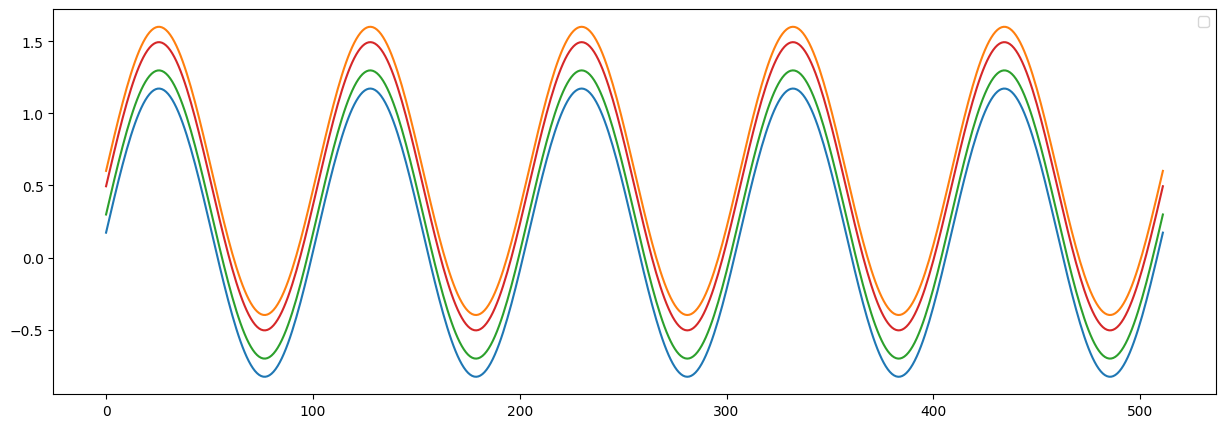

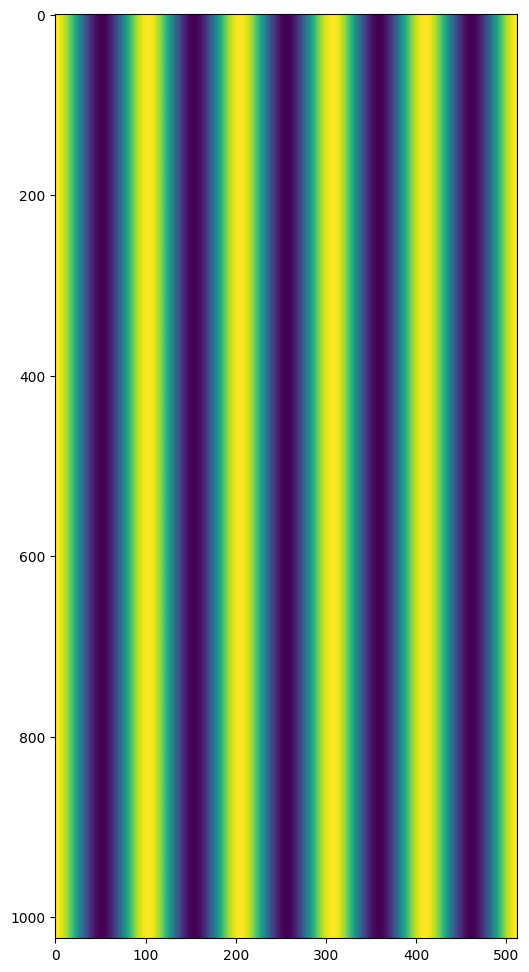

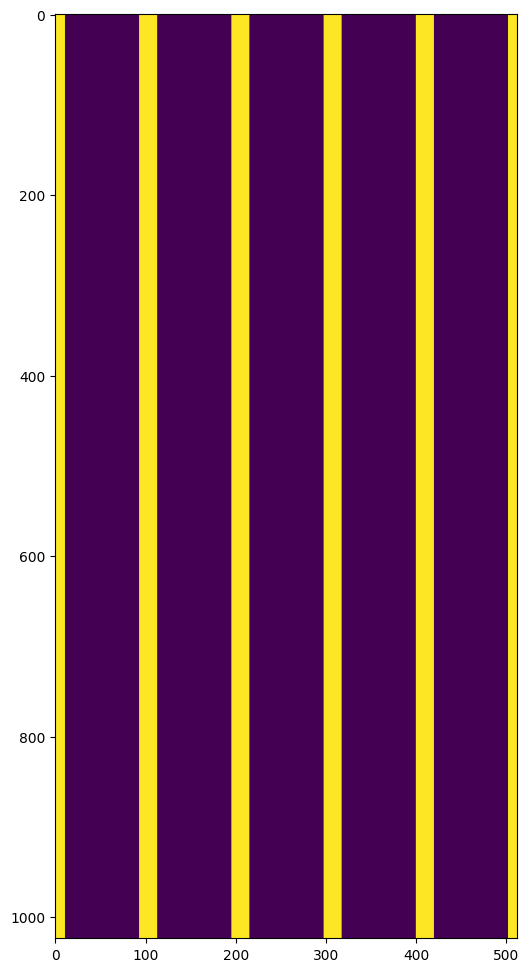

torch.Size([1024, 1, 512])


In [2]:
n = 5
r = 1024
x = torch.linspace(0, n*2*np.pi, 256*2)
x2 = x.unsqueeze(1).repeat_interleave(r, dim=1)
y = torch.sin(x2)
y += torch.normal(0., 0.5, size=(r,))

plt.figure(figsize=(15,5))
sns.lineplot(data=y[:,[1,2,3,4]].numpy(), dashes=False)
plt.legend([], [])
plt.show()

y_grad = torch.tensor(np.gradient(y, axis=0)).transpose(0, 1)
# add randomization after labels are divised, to include some robustness testing
y += torch.randn_like(y) * .35

plt.figure(figsize=(12,12))
plt.imshow(y_grad.numpy())
plt.show()

label_mask = ((y_grad > .05) & (y_grad > -.05)) #.transpose()

plt.figure(figsize=(12,12))
plt.imshow(label_mask.numpy())
plt.show()

labels = label_mask.unsqueeze(1).to(torch.float32)
print(labels.shape)

In [3]:
def conv_out_size(conv_in, kernel_size, stride=1):
    # assumes no padding
    return math.floor((conv_in - (kernel_size - 1) - 1) / stride + 1)

def single_conv(in_channels, out_channels, kernel_size=3, pad=True):
    layer = nn.Sequential(
        nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size, 
            padding=0 if not pad else math.floor(kernel_size / 2),
        ),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layer

def double_conv(in_channels, out_channels, **conv_kwargs):
    layer = nn.Sequential(
        single_conv(in_channels, out_channels, **conv_kwargs),
        single_conv(out_channels, out_channels, **conv_kwargs),
    )
    return layer

def triple_conv(in_channels, mid_channels, out_channels, **conv_kwargs):
    layer = nn.Sequential(
        single_conv(in_channels, mid_channels, **conv_kwargs),
        single_conv(mid_channels, mid_channels, **conv_kwargs),
        single_conv(mid_channels, out_channels, **conv_kwargs),
    )
    return layer

class Unet1d(nn.Module):
    def __init__(
        self, 
        init_upscale=8,
        n_blocks=3,
        depth_factor=3,
        kernel_size=3,
        stride=2,
        in_channels=1,
    ):
        super(Unet1d, self).__init__()
        self.conv_down_blocks = nn.ModuleList()
        self.pool_down_layers = nn.ModuleList()
        self.conv_up_blocks = nn.ModuleList()
        self.tran_up_layers = nn.ModuleList()
        assert kernel_size % 2

        self.input = single_conv(in_channels, init_upscale)
        channels = init_upscale
        for i in range(n_blocks):
            self.conv_down_blocks.append(
                double_conv(
                    channels, 
                    channels * depth_factor,
                )
            )
            channels *= depth_factor
            self.pool_down_layers.append(
                nn.MaxPool1d(stride)
            )
            
        self.mid_layer = triple_conv(channels, channels * depth_factor, channels)
        for i in range(n_blocks):
            self.tran_up_layers.append(
                nn.ConvTranspose1d(
                    channels, 
                    channels, 
                    kernel_size, 
                    stride,
                    padding=math.floor(kernel_size / 2),
                    output_padding=1,
                )
            )
            self.conv_up_blocks.append(
                triple_conv(
                    channels, # * 2
                    channels, 
                    channels // depth_factor,
                )
            )
            channels //= depth_factor
            
        self.output = single_conv(channels, 1)
        return
           
    def forward(self, x):
        original_shape = x.shape
        residuals = list()
        x = self.input(x)
        for conv_down_block, pool_down_layer in zip(self.conv_down_blocks, self.pool_down_layers):
            x = conv_down_block(x)
            residuals.append(x)
            x = pool_down_layer(x)
            
        x = self.mid_layer(x)
        for conv_up_block, residual, tran_up_layer in zip(self.conv_up_blocks, reversed(residuals), self.tran_up_layers):
            x = tran_up_layer(x)
            x = torch.add(x, residual)
            x = conv_up_block(x)

        x = self.output(x)
        assert x.shape == original_shape, f'{x.shape} != {original_shape}'
        x = torch.sigmoid(x)
        return x

In [4]:
def plot_pred_label(preds, labels):
    preds = preds.clone().squeeze(1).detach().numpy()
    labels = labels.squeeze(1).detach().numpy()
    
    plt.figure(figsize=(15,15))
    plt.plot(preds[0,:], label='pred')
    plt.plot(labels[0,:], label='label')
    plt.legend()
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.imshow(preds)
    ax2.imshow(labels)
    plt.show()
    return

In [5]:
def std(arr, n=None, ddof=1):
    n = len(arr) if n is None else n
    if n <= 1 or n - ddof <= 0:
        raise ZeroDivisionError

    squared_dev = np.sum(np.square(arr - np.mean(arr)))
    variance = squared_dev / (n - ddof)
    std_dev = variance ** .5
    return std_dev

def sortino(arr, random_score=0, baseline=0):
    downside_arr = arr - baseline
    downside_arr = downside_arr[downside_arr < 0]
    downside_std = std(downside_arr, n=arr.shape[0], ddof=0)
    
    if not round(downside_std, 9):
        raise ZeroDivisionError
        
    excess = np.mean(arr) - random_score
    sortino_ratio = excess / downside_std
    return sortino_ratio

def cross_val_score(x, method='sortino'):
    x = np.asarray(x)
    if method == 'sortino':
        return -sortino(x)
    elif method == 'mean':
        return np.mean(x)
    raise ValueError(f'Invalid method {method} passed')

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class KFoldLoader:
    def __init__(self, data, labels, n_folds=12, batch_size=32, shuffle=True):
        assert data.shape == labels.shape, f'{data.shape} | {labels.shape}'
        if shuffle:
            random_indices = torch.randperm(data.shape[0])
        self._data = data[random_indices,:] if shuffle else data
        self._labels = labels[random_indices,:] if shuffle else labels        
        self.n_folds = n_folds
        return

    def data_gen(self):
        fold_size = data.shape[0] // self.n_folds
        for fold_num in range(self.n_folds):
            start_idx = fold_num * fold_size
            end_idx = start_idx + fold_size
            if end_idx >= self._data.shape[0]:
                end_idx = self._data.shape[0] - 1

            indices = torch.arange(self._data.shape[0])
            train_indices = indices[start_idx:end_idx]
            test_indices = indices[~torch.isin(indices,train_indices)]
            
            train_data = self._data[train_indices,:]
            train_label = self._labels[train_indices,:]
            test_data = self._data[test_indices,:]
            test_label = self._labels[test_indices,:]
            yield train_data, train_label, test_data, test_label
            
data = (y - y.mean()) / y.std()
kfold = KFoldLoader(data.transpose(0,1).unsqueeze(1), labels, n_folds=8)

In [7]:
n_epochs = 64
min_epoch = 8
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
model_params = [{'n_blocks':2},{'n_blocks':3},{'n_blocks':4}]

model_scores = list()
for model_param in model_params:
    model = Unet1d(**model_param)
    print(model_param)
    optimizer = optim.NAdam(model.parameters(), lr=.1)
    annealer = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-5)
    
    cv_loss = list()
    for fold, (train_data, train_label, test_data, test_label) in enumerate(kfold.data_gen()):
        print('Fold', fold)
        model_loss = list()
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            train_preds = model(train_data)
            
#             if epoch > 0 and not epoch % 32:
#                 plot_pred_label(preds, labels)

            loss = criterion(train_preds, train_label)
            loss.backward()
            optimizer.step()
            annealer.step()
            
            test_preds = model(test_data)
            test_loss = criterion(test_preds, test_label)
            model_loss.append((loss.item(), test_loss.item()))
            if epoch >= min_epoch and test_loss < loss:
                # add early stopping instead
                break

        cv_loss.append(test_loss.item())
    
    model_scores.append((cross_val_score(cv_loss), model_param))
    
scores, params = zip(*model_scores)
best_idx = np.argmin(scores)
best_score = scores[best_idx]
best_param = params[best_idx]
print(best_score, best_param)

{'n_blocks': 2}
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: 